<a href="https://colab.research.google.com/github/linhoangce/ml_with_pytorch_and_scikitlearn/blob/main/chapter14_cnn_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Topics covered:

* Convolutional operations in one and two dimensions
* The building blocks of CNN architectures
* Implementing deep CNNs in PyTorch
* Data augmentation techniques for improving the generalization performance
* Implementing a facial CNN classifier for recognizing if someone is smiling or not



# The building blocks of CNNs

## Understanding CNNS and feature hierarchies

Certain types of NNs, such as CNNs, can automatically learn the features from raw data that are most useful for a particular task. For this reason, it's common to consider CNN layers as feature extractors: the early layers extract **low-level features** from raw data, and the later layers (often **fully connected layers**, as ain a multilkayer perceptron) use these features to predict a continuous target value or class label.

A CNN computes **feature maps** from an input image, where each element comes from a local patch of pixels in the input image. This local patch of pixels is referred to as the **local receptive field**. CNN will usually perform well on image-related tasks, and that's large;y due to two important ideas:

* **Sparse connectivity**: A single element in the feature map is connected to only a small patch of pixels.

* **Parameter sharing**: The same weights are used for different patches of the input image.

As a direct consequence of these two ideas, replacing a conventional, fully connected MLP with a convolutional layer substantially decreases the number of weights in the network, and increase the ability to capture *salient* (relevant) features.

Typically, CNNs are composed of several **convolutional** and subsampling layers that are followed by one or more fully connected layers at the end.

Subsampling layers, commonly known as **pooling layers**, do not have any learnable parameters (weights and biases) as convolutional and fully connected layers that are used for optimization during training.

## Performing discrete convolutions

### Discrete convolutions in one dimension

Let's assume that the original input, x and filter, **w**, have *n* and *m* elements, respectively, where $m\leq n$. Therefore, the padded vector $x^p$, has size $n + 2p$. The practical formulate for computing a discrete convolution is:

$$ y = x * w \rightarrow y[i] = \sum_{k=0}^{k=m-1}x^p[i + m -k]w[k] $$

The important point to notice here is that **x** and **w** are indexed in opposite directions in the summation. Computing the sum with one index going in the reverse direction is equivalent to computing the sum of both indices in the forward direction after flipping one of those vectors, **x** or **w**, after they are padded. Then, we can simply compyte their dot product. Let's assume we flip (rotate) the filter, **w**, to get the rotated filter, **$w^T$**. Then the dot product, $x[i:i + m].w^T$, is computed to get one element, $y[i]$, where $x[i:i + m]$ is a patch of x with size *m*. This operation is repeated like in a sliding window approach to get all the output elements.

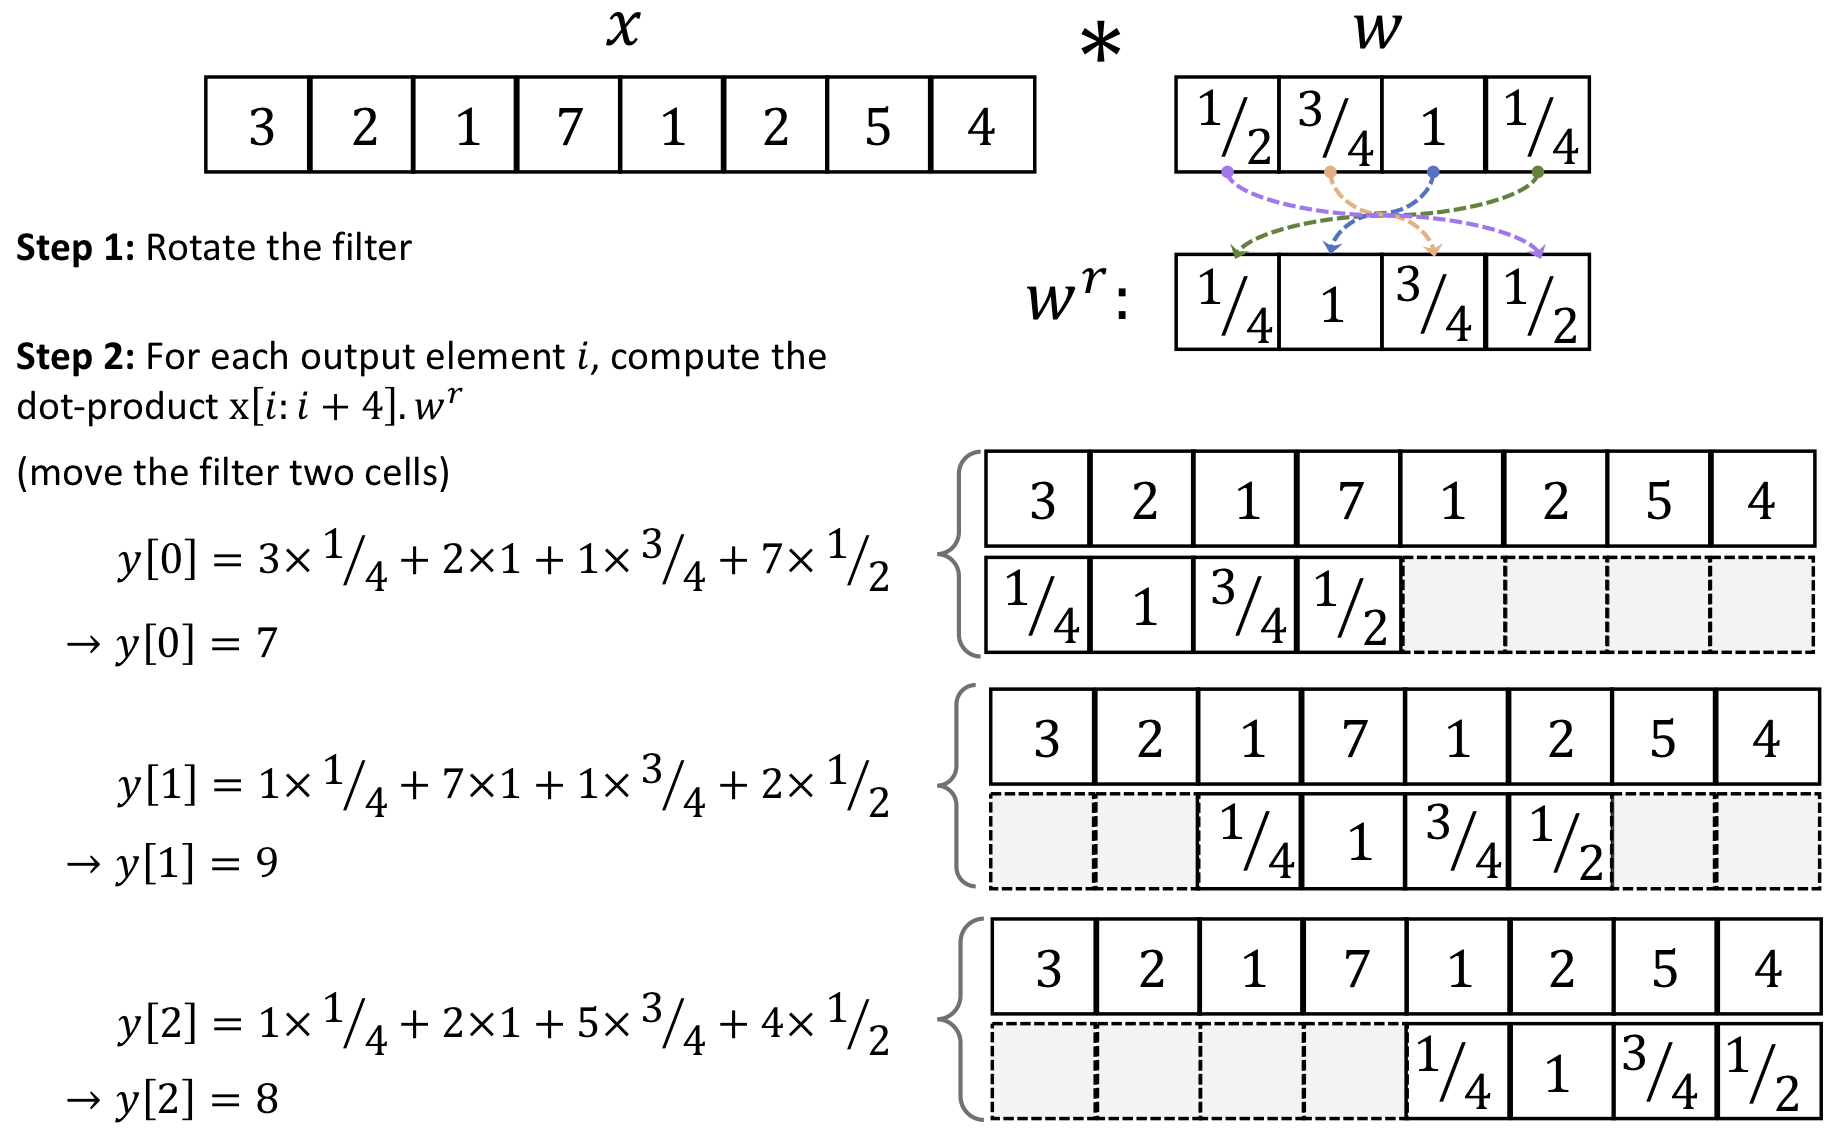

In [1]:
from IPython.display import Image

Image('https://raw.githubusercontent.com/rasbt/machine-learning-book/main/ch14/figures/14_03.png')

### Padding inputs to control the size of the output feature maps

There are three modes of padding that are commonly used in practice: *full*, *same*, and *valid*.

In full mode, the padding parameter, *p*, is set to $p = m - 1$. Full padding increases the dimension of the output; thus, it is rarely used in CNN architectures.

The **same padding** mode is usually used to ensure that the output vector has the same size as the input vector, $x$. In this case, the padding parameter, $p$, is computed according to the filter size, along with the requirement that the input size and output size are the same.

Finally, computing a convolution in **valid mode** refers to the case where $p = 0$ (no padding)

The most commonly used padding mode in CNNs is same padding. One of its advantages over the other padding modes is that same padding preserves the sizes of the vector - or the height and width of the input images when we are wroking on image-related tasks in computer vision - which makes designing a network architecture more convenient.

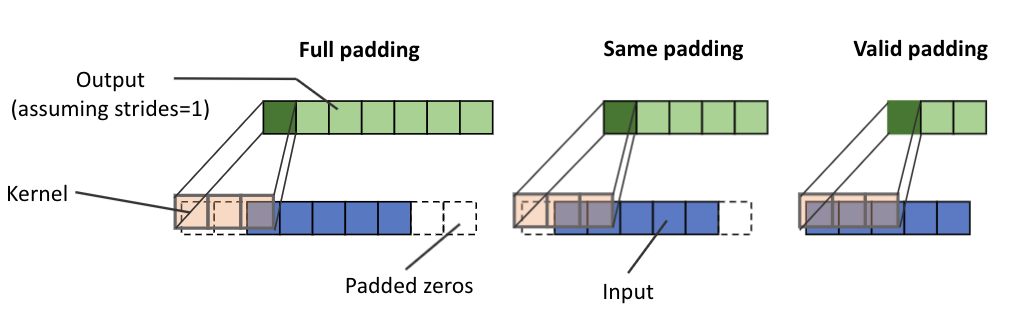

In [2]:
Image('https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/ch14/figures/14_04.png')

### Determining the size of the convolution output

The output size of a convolution is determined by the total number of times that we shift the filter, $w$, along the input vector. Let's assume that the input vector is of size $n$ and the filter is of size $m$. Then, the size of the output resulting from $\textit{y} = \textit{x * w}$, with padding $p$ and stride $s$, awould be determined as follows:

$$ o = \lfloor\frac{n + 2p - m}{s}\rfloor + 1$$

Here $\lfloor.\rfloor$ denotes the *floor* operation, which returns the largest integer that is equal to or smaller than the input.

* Compute the output size for an input vector of size 10 with a convolution kernel of size 5, padding 2, and stride 1:

$$ n = 10, m = 5, p = 2, s = 1 \rightarrow o = \lfloor\frac{10 + 2\times2 - 5}{1} \rfloor + 1 = 10 $$

* How does the output size change for the same input vector when we have a kernel of size 3 and stride 2:

$$ n = 10, m = 3, p = 2, s = 2 → o = \lfloor \frac{10 + 2\times2 - 3}{2} \rfloor + 1 = 6 $$


In [3]:
# a naive implementation of convolution computation
import numpy as np

def conv1d(x, w, p=0, s=1):
  w_rot = np.array(w[::-1])
  x_padded = np.array(x)

  if p > 0:
    zero_pad = np.zeros(shape=p)
    x_padded = np.concatenate([
        zero_pad, x_padded, zero_pad
    ])
    res = []

    for i in range(0,
                   int((len(x_padded) - len(w_rot))) + 1,
                   s):
      res.append(np.sum(x_padded[i : i+w_rot.shape[0]] * w_rot))

    return np.array(res)

## TEsting
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]
print(f'Conv1d implementation: {conv1d(x, w, p=2, s=1)}')
# compare to `np.convolve()`
print(f'NumPy results: {np.convolve(x, w, mode='same')}')

Conv1d implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
NumPy results: [ 5 14 16 26 24 34 19 22]


### Performing a discrete convolution in 2D

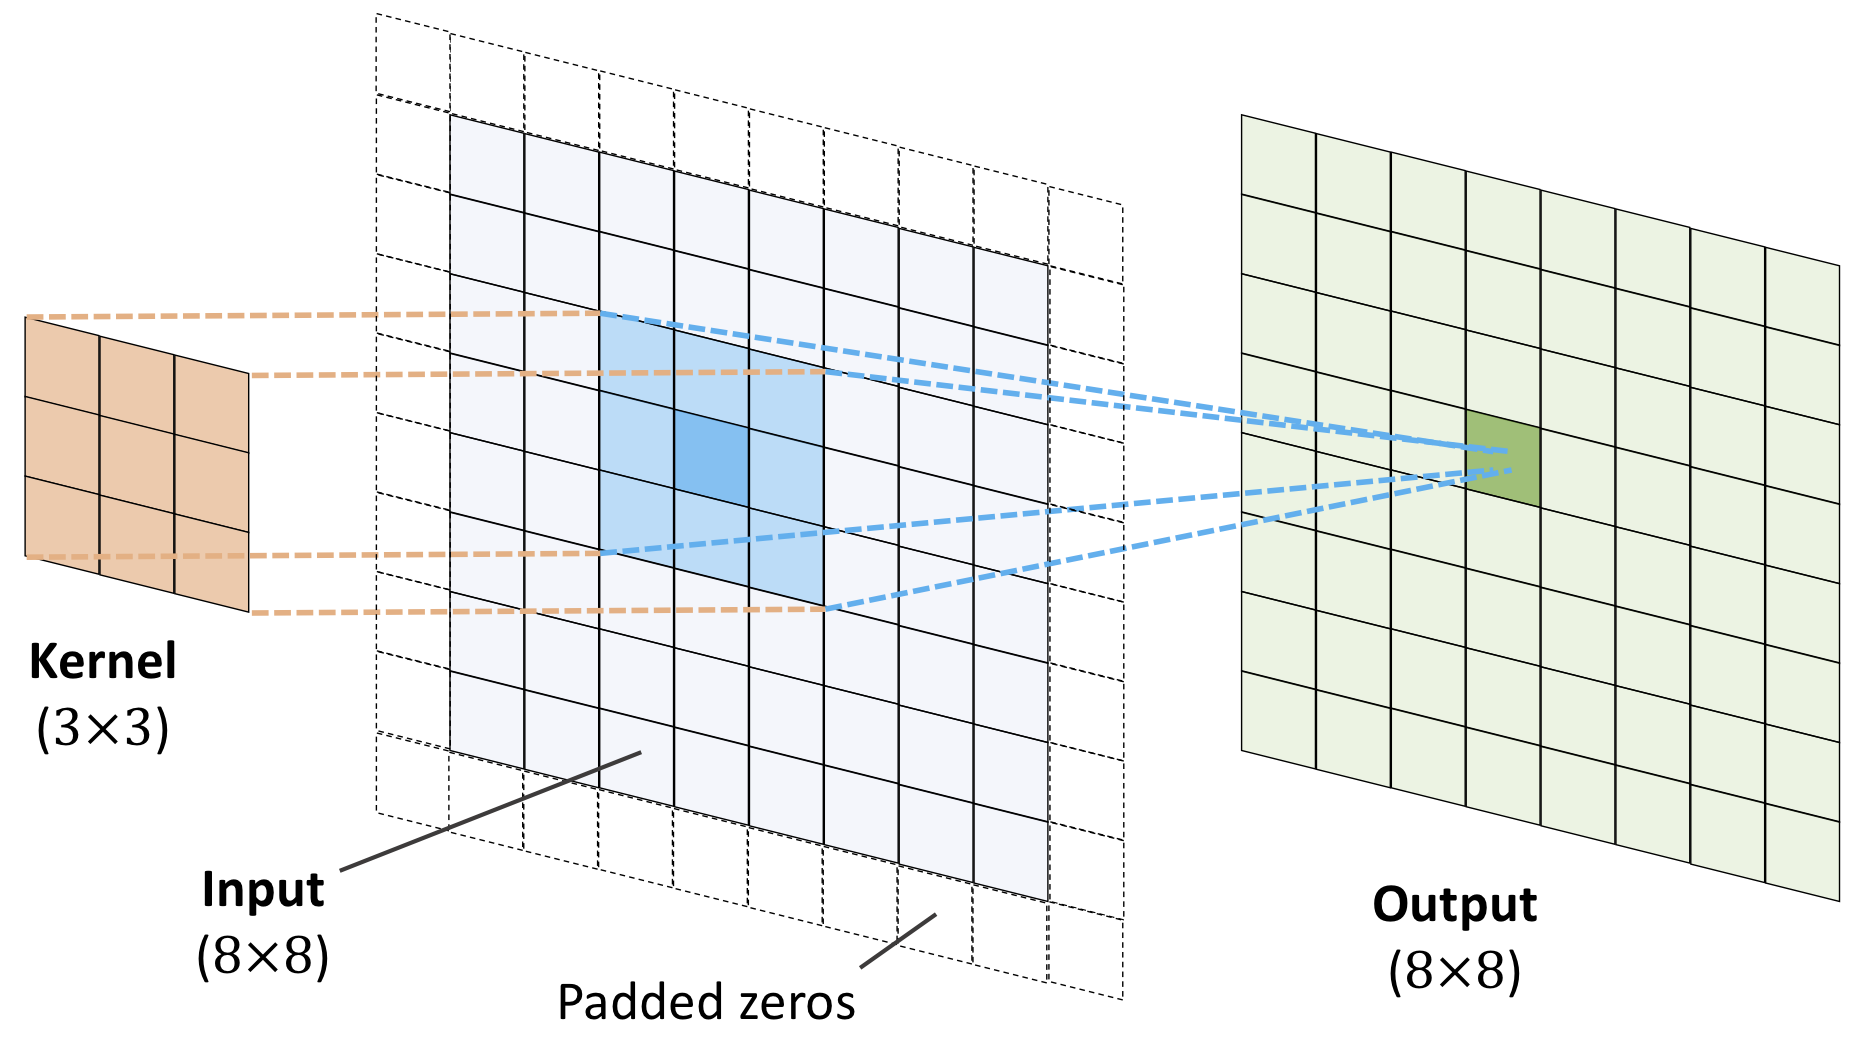

In [4]:
from IPython.display import Image

Image('https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/ch14/figures/14_05.png')

The following example illustrates the computation of a 2D convolution between an input matrix $X_{3x3}$, and a kernel matrix, $W_{3x3}$, using padding $p = (1,1)$ and stride $s = (2, 2).

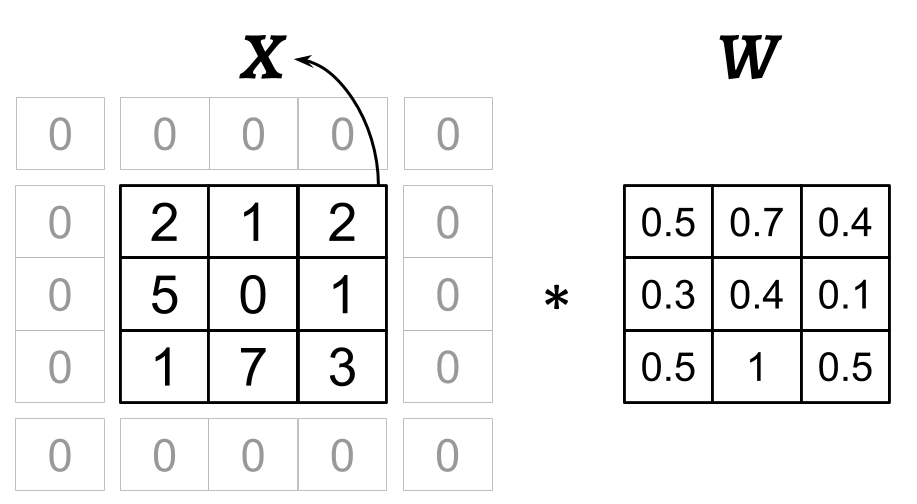

In [5]:
Image('https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/ch14/figures/14_06.png')

In [6]:
w = [[0.5, 0.7, 0.4],
     [0.3, 0.4, 0.1],
     [0.5, 1, 0.5]]

w = np.array(w)
w_r = w[::-1,::-1]
w_r

array([[0.5, 1. , 0.5],
       [0.1, 0.4, 0.3],
       [0.4, 0.7, 0.5]])

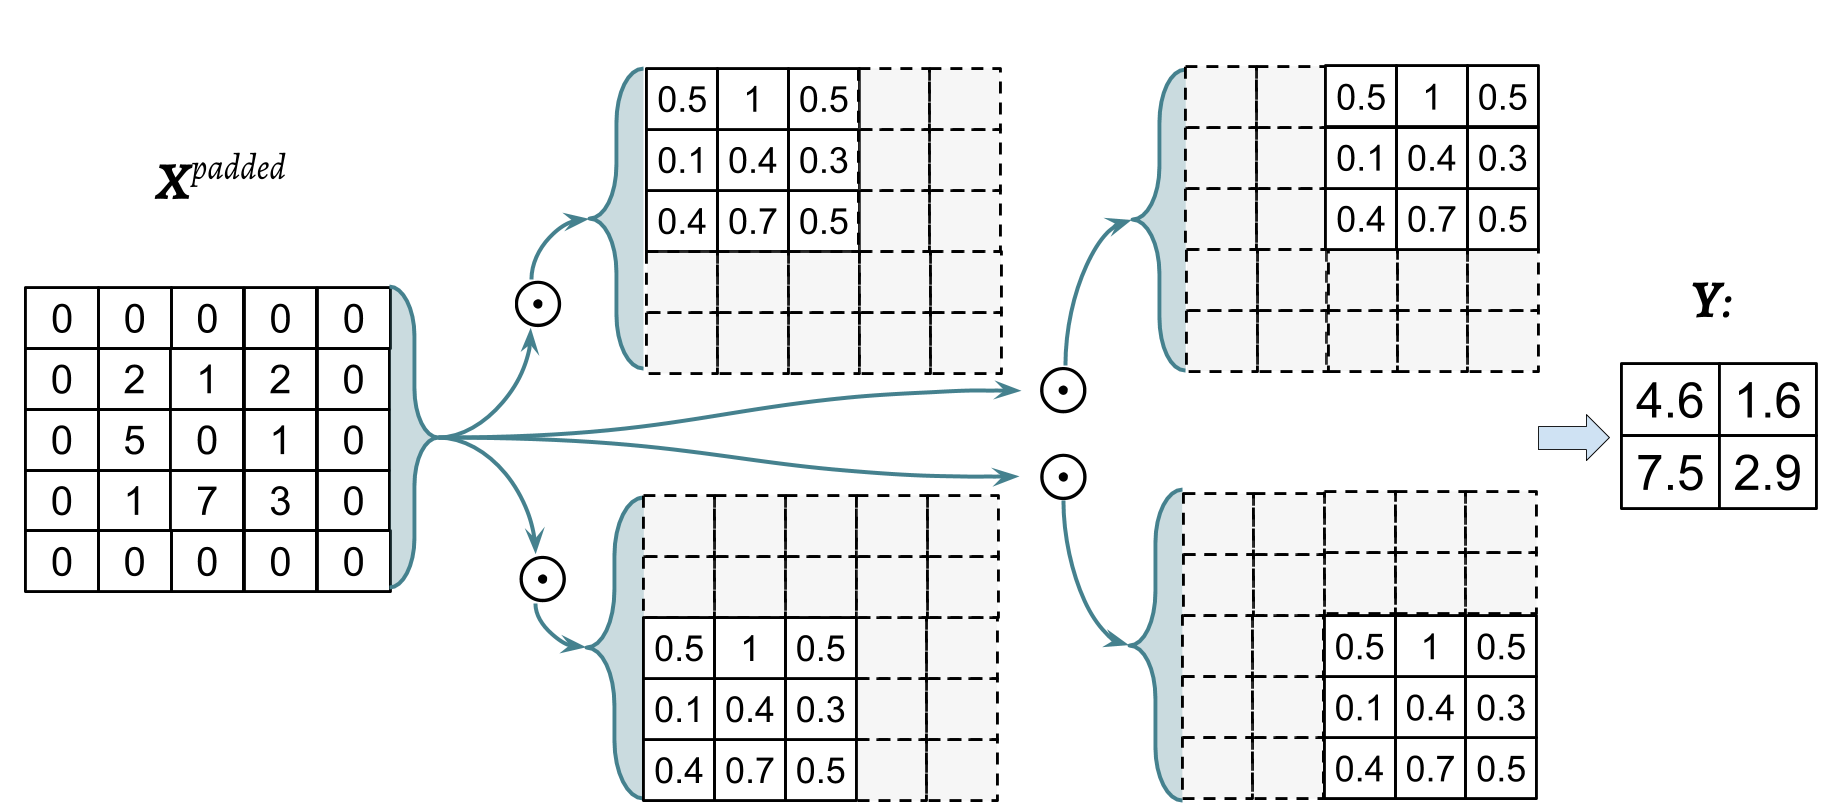

In [7]:
Image('https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/ch14/figures/14_07.png')

In [8]:
# implement a 2d convolution based on described naive algorithm
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
  W_rot = np.array(W)[::-1, ::-1]
  X_orig = np.array(X)
  n1 = X_orig.shape[0] + 2*p[0]
  n2 = X_orig.shape[1] + 2*p[0]
  X_padded = np.zeros(shape=(n1, n2))
  X_padded[p[0] : p[0]+X_orig.shape[0],
           p[1] : p[1]+X_orig.shape[1]] = X_orig

  res = []

  for i in range(0,
                 int((X_padded.shape[0] - W_rot.shape[0]) / s[0]) + 1,
                 s[0]):
    res.append([])

    for j in range(0,
                   int((X_padded.shape[1] - W_rot.shape[1]) / s[1]) + 1,
                   s[1]):
      X_sub = X_padded[i : i+W_rot.shape[0],
                       j : j+W_rot.shape[1]]
      res[-1].append(np.sum(X_sub * W_rot))

  return (np.array(res))

X = [[1, 3, 2, 4],
     [5, 6, 1, 3],
     [1, 2, 0, 2],
     [3, 4, 3, 2]]
W = [[1, 0, 3],
     [1, 2, 1],
     [0, 1, 1]]

print(f'Conv2d implementation: \n {conv2d(X, W, p=(1, 1), s=(1, 1))}')
print(f'Scipy results:\n {scipy.signal.convolve2d(X, W, mode='same')}')

Conv2d implementation: 
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
Scipy results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## Subsampling layers

Subsampling is typically applied in two forms of pooling operations in CNNs: **max-pooling** and **mean-pooling** (also known as average-pooling). The pooling layer is usually denoted by $P_{n_1\times n_2}$. Here the subscript determines the size of the neighborhood (the number of adjacent pixels in each dimension) where the max or mean operation is performed. We refer to such a neighborhood as the **pooling size**.

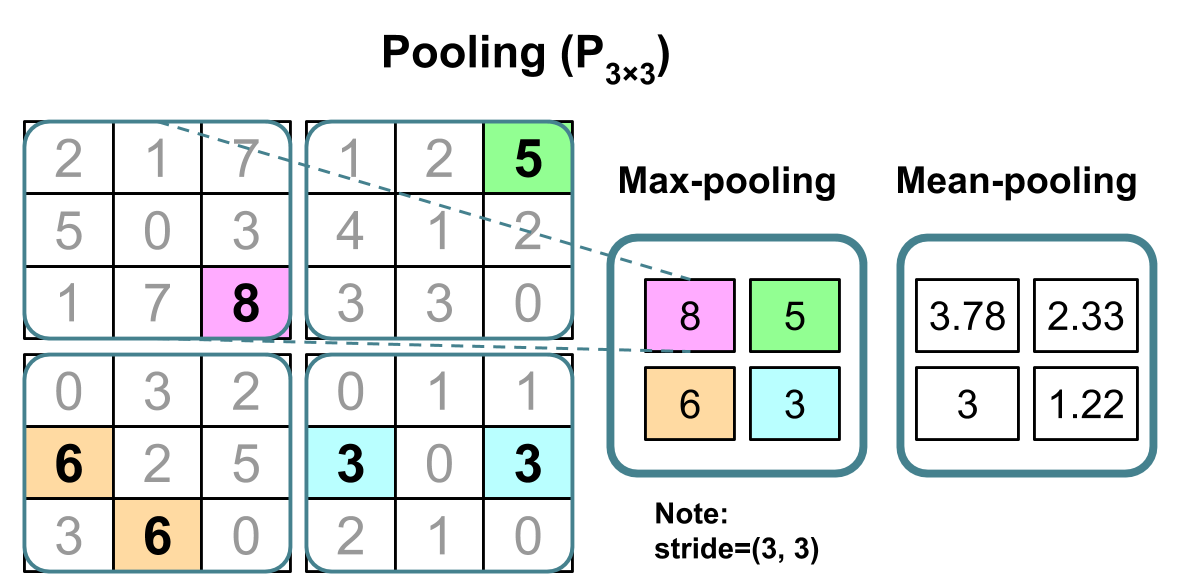

In [9]:
Image('https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/ch14/figures/14_08.png')

The advantage of pooling is twofold:

* Pooling (max-pooling) introduces a local invariance. This means that small changes in a local neighborhood do not change the result of max-pooling. Therefore, it heps with generating features that are more robust to noise in the input data. Refere

* Pooling decreases the size of features, which results in higher computational efficiency. Furthermore, reducing the number of features may reduce the degree of overfitting as well.

**Over lapping vs. non-overlapping pooling**

Traditionally, pooling is assumed to be non-overlapping. Pooling is typically performed on non-overlapping neighborhoods, which can done by setting the stride parameter equal to the pooling size. For example, a non-overlapping pooling layer, $P_{n_1\times n2}$, requires a stride parameter $s=(n1, n2)$.

On the other hand, overlapping pooling occurs if the stride is smaller than the pooling size. An example where overlapping poolin is used in the winning AlexNet model.

# Putting everything together - implementing a CNN

## Working with multiple input or color channels

An input to a convolutional layer may contain one or more 2D arrays or matrices with dimensions $N_1\times N_2$ (for example, the image height and width in pixels). These $N_1\times N_2$ matrices are called *channels.* Conventional implementations of convolutional layers expect a rank-3 tensor representaion as input, for example, a three-dimensional array, $\textbf{X}_{N_1\times N_2\times C_{in}}$, wher $C_{in}$ is the number of input channels. For example, let's consider images as input to the first layer of a CNN. If the image is colored and uses the RGB color mode, then $C_{in} = 3$. However, $C_{in} = 1$ for gray-scale images.

For convolution operation with multiple input channels, we perform the convolution for each channel separately and then add the results together using the matrix summation. The convolution associated with each channel ($c$) has its own kernel matrix as $W[:,:,c]$.

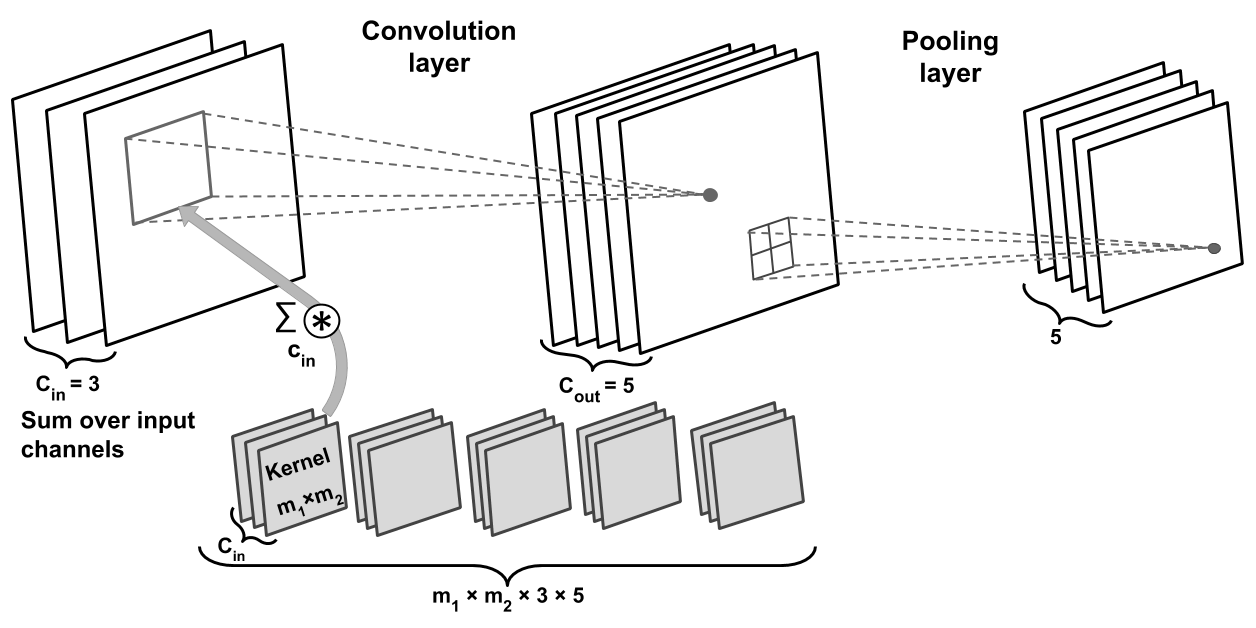

In [10]:
Image('https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/ch14/figures/14_09.png')

## Regularizing an NN with L2 regularization and dropout

In [11]:
# implement L2 regularization in fully connected NN
from torch import nn
import torch

loss_fn = nn.BCELoss()

loss = loss_fn(torch.tensor([0.9]),
               torch.tensor([1.0]))
l2_lambda = 0.001

conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=5,
                       kernel_size=5)


In [12]:
loss

tensor(0.1054)

In [13]:
[p for p in conv_layer.parameters()]

[Parameter containing:
 tensor([[[[ 0.0755,  0.0503, -0.0425,  0.0697, -0.0959],
           [ 0.0126, -0.1090,  0.0127, -0.0209, -0.0800],
           [-0.0428, -0.0769,  0.0397, -0.0364, -0.0608],
           [ 0.1082, -0.0270,  0.1035, -0.0143,  0.0309],
           [ 0.0727, -0.0057, -0.0526,  0.0712, -0.0335]],
 
          [[ 0.0024, -0.0737,  0.0876, -0.0894,  0.0667],
           [ 0.0213,  0.0748, -0.0723, -0.0574, -0.0820],
           [-0.0383,  0.0477, -0.1122, -0.0942,  0.0739],
           [ 0.0907,  0.0253,  0.0100, -0.0571,  0.1021],
           [-0.0865,  0.1152, -0.0132,  0.0947,  0.0969]],
 
          [[-0.1001, -0.0493, -0.0632,  0.0964, -0.0700],
           [ 0.0567, -0.0418,  0.1047, -0.0754,  0.1091],
           [ 0.0244, -0.0500, -0.0135,  0.0502, -0.0176],
           [ 0.0804,  0.0566,  0.0366, -0.1099, -0.0406],
           [ 0.0659, -0.0834, -0.0605, -0.0484,  0.0030]]],
 
 
         [[[ 0.0242,  0.0991,  0.0093, -0.0159, -0.1115],
           [-0.0062, -0.0023, -0.0430

In [14]:
[(p**2).sum() for p in conv_layer.parameters()]

[tensor(1.6515, grad_fn=<SumBackward0>),
 tensor(0.0191, grad_fn=<SumBackward0>)]

In [15]:
sum([(p**2).sum() for p in conv_layer.parameters()])

tensor(1.6706, grad_fn=<AddBackward0>)

In [16]:

l2_penalty = l2_lambda * sum(
    [(p**2).sum() for p in conv_layer.parameters()]
)
l2_penalty

tensor(0.0017, grad_fn=<MulBackward0>)

In [17]:
loss_with_penalty = loss + l2_penalty
loss_with_penalty

tensor(0.1070, grad_fn=<AddBackward0>)

In [18]:
linear_layer = nn.Linear(10, 16)

l2_penalty = l2_lambda * sum(
    [(p**2).sum() for p in linear_layer.parameters()]
)

loss_with_penalty = loss + l2_penalty
loss_with_penalty

tensor(0.1110, grad_fn=<AddBackward0>)

## Loss functions for classification

In [19]:
#############################
### Binary Cross-entropy
#############################
logits = torch.tensor([0.8])
probs = torch.sigmoid(logits)
target = torch.tensor([1.0])

bce_loss = nn.BCELoss()
bce_logits_loss = nn.BCEWithLogitsLoss()

print(f'BCE (w probs): {bce_loss(probs, target):.4f}')
print(f'BCE (w logits): {bce_logits_loss(logits, target):.4f}')

BCE (w probs): 0.3711
BCE (w logits): 0.3711


In [20]:
###############################
### Categorical Cross-entropy
###############################

logits = torch.tensor([[1.5, 0.8, 2.1]])
probs = torch.softmax(logits, dim=1)
target = torch.tensor([2])

cce_loss = nn.NLLLoss()
cce_logits_loss = nn.CrossEntropyLoss()

print(f'CCE (w probs): {cce_loss(torch.log(probs), target):.4f}')
print(f'CCE (w logits): {cce_logits_loss(logits, target):.4f}')

CCE (w probs): 0.5996
CCE (w logits): 0.5996


# Implementing a deep CNN using PyTorch

## The multilayer CNN architecture

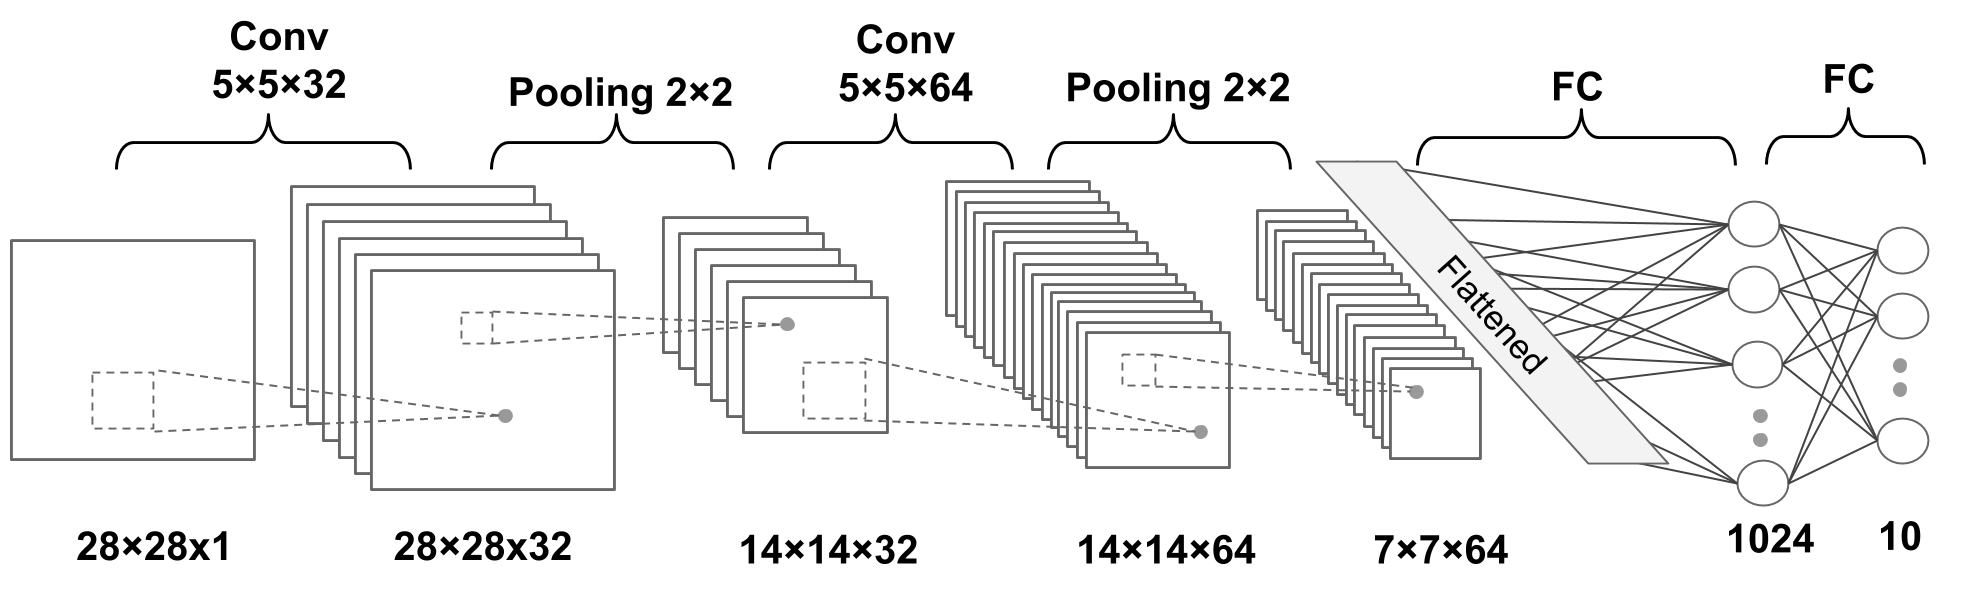

In [21]:
Image('https://raw.githubusercontent.com/rasbt/machine-learning-book/refs/heads/main/ch14/figures/14_12.png')

The dimensions of the tensors in each layer are as follows:

* Input: [$batchsize\times 28\times 28\times 1$]
* Conv_1: [$batchsize \times 28 \times 28 \times 32$]
* Pooling_1: [$batchsize \times 14 \times 14 \times 32$]
* Conv_2: [$batchsize \times 14 \times 14 \times 64$]
* Pooling_2: [$batchsize \times 7 \times 7 \times 64$]
* FC_1: [$batchsize \times 1024$]
* FC_2 and softmax layer: [$batchsize \times 10$]

$ stride=1$ and $\text{kernel_size}=2$

## Loading and preprocessing the data

In [22]:
import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose([
    transforms.ToTensor()
])

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 503kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.67MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.46MB/s]


In [23]:
from torch.utils.data import Subset

# split train set into train and validation sets
mnist_valid_dataset = Subset(mnist_dataset,
                             torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset,
                             torch.arange(10000,
                                          len(mnist_dataset)))

mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                         train=False,
                                         transform=transform,
                                         download=True)

In [24]:
# construct data loader with batches of 64
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(dataset=mnist_train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
valid_dl = DataLoader(dataset=mnist_valid_dataset,
                      batch_size=batch_size,
                      shuffle=False)

In [25]:
for x, y in train_dl:
  print(x[:1], y[:1])
  break

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

## Constructing a CNN in PyTorch

In [26]:
from torch import nn

model = nn.Sequential()

model.add_module('conv1',
                 nn.Conv2d(in_channels=1,
                           out_channels=32,
                           kernel_size=5,
                           padding=2)
)
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2',
                 nn.Conv2d(in_channels=32,
                           out_channels=64,
                           kernel_size=5,
                           padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))


This model uses same padding mode to preserve the spatial dimensions of the feature maps. The spatial dimension of the output feature map is calculated by:

$$ o = \lfloor \frac{n + 2p -m}{s} + 1 \rfloor $$

where $n$ is the spatial dimension of the input feature map, and $p, m$ and $s$ denote the padding, kernel size, and stride, respectively. We obtain $p = 2$ to achieve $o = i$

In [27]:
# check the size of feature maps
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [28]:
# add a fully connected layer for implementing a classifier
# on top of our convolutional and pooling layers
# the input to this layer must have rank 2, shape [batchsize x inputsize]
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 1, 28, 28))
model(x).shape # 64x7x7 = 3136

torch.Size([4, 3136])

In [29]:
# add two fully connected layers with a dropout layer in between
# softmax is implemented internally in PyTorch's `CrossEntropyLoss`
# so we don't need to explicitly add it as a layer at the end
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))


In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [31]:
# define the train function
def train(model, epochs, train_dl, valid_dl):
  loss_hist_train = [0] * epochs
  acc_hist_train = [0] * epochs
  loss_hist_valid = [0] * epochs
  acc_hist_valid = [0] * epochs

  model.to(device)

  for epoch in range(epochs):
    model.train()

    for x_batch, y_batch in train_dl:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      y_pred = model(x_batch)
      loss = loss_fn(y_pred, y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # rescales average batch loss back to total loss for all samples
      # `nn.CrossEntropyLoss` computes mean loss per sample in batch
      # `y_batch.size(0) == batch_size == 64
      loss_hist_train[epoch] += loss.item() * y_batch.size(0)
      is_correct = (torch.argmax(y_pred, dim=1) == y_batch).float()
      acc_hist_train[epoch] += is_correct.sum().cpu().item()

    loss_hist_train[epoch] /= len(train_dl.dataset)
    acc_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.inference_mode():
      for x_batch, y_batch in valid_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

        loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(y_pred, dim=1) == y_batch).float()
        acc_hist_valid[epoch] += is_correct.sum().cpu().item()

    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    acc_hist_valid[epoch] /= len(valid_dl.dataset)

    print(f'Epoch {epoch+1} | Acc: {acc_hist_train[epoch]:.4f} |'
          f'Val_acc: {acc_hist_valid[epoch]:.4f}')

  return loss_hist_train, loss_hist_valid, \
            acc_hist_train, acc_hist_valid

In [32]:
torch.manual_seed(1)

epochs = 20

hist = train(model, epochs, train_dl, valid_dl)

Epoch 1 | Acc: 0.9512 |Val_acc: 0.9824
Epoch 2 | Acc: 0.9843 |Val_acc: 0.9871
Epoch 3 | Acc: 0.9898 |Val_acc: 0.9848
Epoch 4 | Acc: 0.9924 |Val_acc: 0.9879
Epoch 5 | Acc: 0.9929 |Val_acc: 0.9890
Epoch 6 | Acc: 0.9943 |Val_acc: 0.9882
Epoch 7 | Acc: 0.9954 |Val_acc: 0.9893
Epoch 8 | Acc: 0.9963 |Val_acc: 0.9863
Epoch 9 | Acc: 0.9964 |Val_acc: 0.9899
Epoch 10 | Acc: 0.9965 |Val_acc: 0.9916
Epoch 11 | Acc: 0.9969 |Val_acc: 0.9903
Epoch 12 | Acc: 0.9974 |Val_acc: 0.9903
Epoch 13 | Acc: 0.9972 |Val_acc: 0.9919
Epoch 14 | Acc: 0.9983 |Val_acc: 0.9909
Epoch 15 | Acc: 0.9979 |Val_acc: 0.9904
Epoch 16 | Acc: 0.9980 |Val_acc: 0.9917
Epoch 17 | Acc: 0.9980 |Val_acc: 0.9909
Epoch 18 | Acc: 0.9985 |Val_acc: 0.9912
Epoch 19 | Acc: 0.9981 |Val_acc: 0.9894
Epoch 20 | Acc: 0.9981 |Val_acc: 0.9902


50000

In [35]:
hist

([0.15723258982181548,
  0.049524000087827445,
  0.032864121957160534,
  0.02423499183261767,
  0.022343068304485642,
  0.016745562644025776,
  0.014392583890771493,
  0.01130255944509321,
  0.010974979781823931,
  0.010419555664482468,
  0.0100262162707487,
  0.008959595763200486,
  0.008066654515705632,
  0.005136747537847732,
  0.006775128429945507,
  0.0072998611681103194,
  0.006532228733875127,
  0.005370054906705664,
  0.006694049616307863,
  0.006564191162186121],
 [0.061483681217581035,
  0.04529983685463667,
  0.047660046672821046,
  0.04322997779245488,
  0.04277155964343692,
  0.04363661480122537,
  0.03853999856293667,
  0.06471811109355913,
  0.04122938341385743,
  0.03867450040111035,
  0.04471259409373224,
  0.041358280306715824,
  0.035327362721264764,
  0.04222795330397698,
  0.05168490272307008,
  0.045406407068126875,
  0.054603182970624574,
  0.05255346436918858,
  0.06674845548440339,
  0.05951303317057008],
 [0.95116,
  0.98428,
  0.98984,
  0.99244,
  0.9929,
  

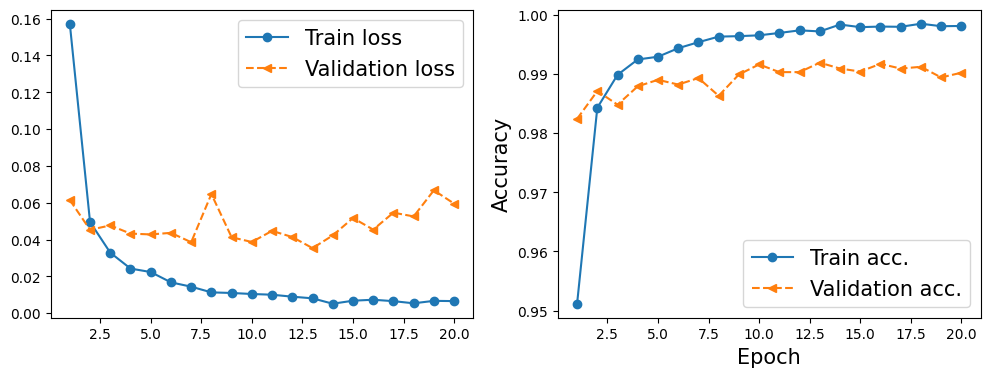

In [36]:
# visualize learning curves
import matplotlib.pyplot as plt

x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [38]:
# evaluate model on test dataset
torch.cuda.synchronize()
model_cpu = model.cpu()

test_pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(test_pred,
                           dim=1) == mnist_test_dataset.targets).float()

print(f'Test acc: {is_correct.mean():.4f}')

Test acc: 0.9927


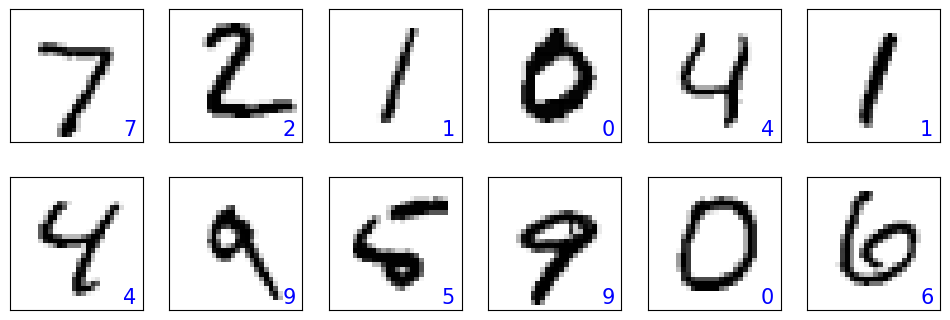

In [39]:
# make predictions -> probabilities -> class labels -> visualize
fig = plt.figure(figsize=(12, 4))

for i in range(12):
  ax = fig.add_subplot(2, 6, i+1)
  ax.set_xticks([]); ax.set_yticks([])
  img = mnist_test_dataset[i][0][0, :, :]
  pred = model(img.unsqueeze(0).unsqueeze(1))
  y_pred = torch.argmax(pred)

  ax.imshow(img, cmap='gray_r')
  ax.text(0.9, 0.1,
          y_pred.item(),
          size=15,
          color='blue',
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)

plt.show()

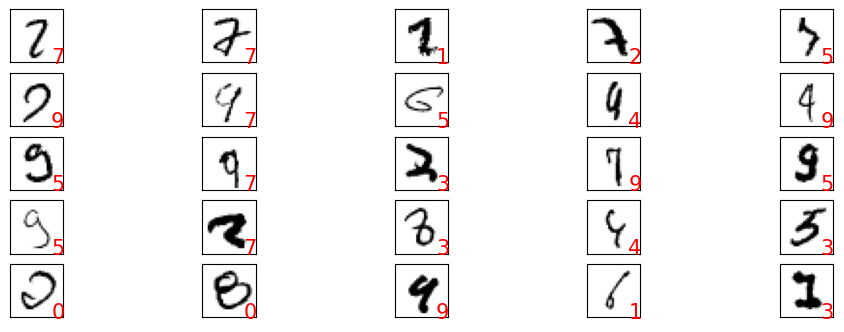

In [66]:
# plot first 25 misclassified samples from test dataset
X_test = mnist_test_dataset.data
y_test = mnist_test_dataset.targets

logits = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
y_pred = logits.argmax(dim=1)

misclassified_img = X_test[y_pred != y_test][:25]
misclasified_labels = y_pred[y_test != y_pred][:25]
correct_labels = y_test[y_test != y_pred][:25]

fig = plt.figure(figsize=(12, 4))

for i in range(25):
  ax = fig.add_subplot(5, 5, i+1)
  ax.set_xticks([]); ax.set_yticks([])

  ax.imshow(misclassified_img[i], cmap='Greys')
  ax.text(0.9, 0.1,
          misclasified_labels[i].item(),
          size=15,
          color='red',
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)

plt.show()


In [63]:
mis.shape

torch.Size([25, 28, 28])